In [2]:
import pandas as pd, numpy as np

In [19]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [45]:
from xgboost import plot_importance
from matplotlib import pyplot
import seaborn as sns

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import log_loss,confusion_matrix,classification_report

In [8]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [6]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [7]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.07322132467681, 590.72028190489186, 5000)

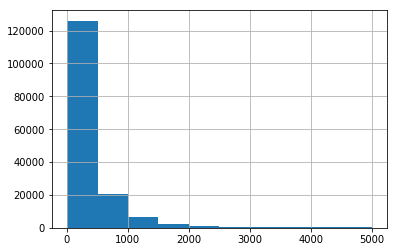

In [9]:
lens.hist()

In [10]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
len(train),len(test)

(159571, 153164)

In [14]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

In [12]:
vect_word = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,2),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(1,4),dtype=np.float32)

In [13]:
tr_vect = vect_word.fit_transform(train['comment_text'])
ts_vect = vect_word.transform(test['comment_text'])

In [14]:
tr_vect_char = vect_char.fit_transform(train['comment_text'])
ts_vect_char = vect_char.transform(test['comment_text'])

In [15]:
X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])

In [16]:
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]

In [27]:
prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target_col):
    model = xgb.XGBClassifier()
    eval_set = [(X, y[col])]
    print('Building {} model for column:{''}'.format(i,col)) 
    model.fit(X,y[col], early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
    #print(model.predict_proba(x_test).shape)
    #cv_score.append(model.score)
    prd[:,i] = model.predict_proba(x_test)[:,1]

Building 0 model for column:toxic
[0]	validation_0-logloss:0.620539
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.561198
[2]	validation_0-logloss:0.512045
[3]	validation_0-logloss:0.470633
[4]	validation_0-logloss:0.435639
[5]	validation_0-logloss:0.405383
[6]	validation_0-logloss:0.379305
[7]	validation_0-logloss:0.357033
[8]	validation_0-logloss:0.337633
[9]	validation_0-logloss:0.320485
[10]	validation_0-logloss:0.305903
[11]	validation_0-logloss:0.292905
[12]	validation_0-logloss:0.281654
[13]	validation_0-logloss:0.271701
[14]	validation_0-logloss:0.262802
[15]	validation_0-logloss:0.254862
[16]	validation_0-logloss:0.247837
[17]	validation_0-logloss:0.241569
[18]	validation_0-logloss:0.235864
[19]	validation_0-logloss:0.230708
[20]	validation_0-logloss:0.226169
[21]	validation_0-logloss:0.221828
[22]	validation_0-logloss:0.217849
[23]	validation_0-logloss:0.214108
[24]	validation_0-logloss:0.211076
[25]	validation_0-logloss:0.20832

[26]	validation_0-logloss:0.10557
[27]	validation_0-logloss:0.102883
[28]	validation_0-logloss:0.100388
[29]	validation_0-logloss:0.098146
[30]	validation_0-logloss:0.09614
[31]	validation_0-logloss:0.094237
[32]	validation_0-logloss:0.092495
[33]	validation_0-logloss:0.090912
[34]	validation_0-logloss:0.089478
[35]	validation_0-logloss:0.088075
[36]	validation_0-logloss:0.086754
[37]	validation_0-logloss:0.085532
[38]	validation_0-logloss:0.084354
[39]	validation_0-logloss:0.083322
[40]	validation_0-logloss:0.082343
[41]	validation_0-logloss:0.081412
[42]	validation_0-logloss:0.080554
[43]	validation_0-logloss:0.079687
[44]	validation_0-logloss:0.078881
[45]	validation_0-logloss:0.078138
[46]	validation_0-logloss:0.077409
[47]	validation_0-logloss:0.076719
[48]	validation_0-logloss:0.076098
[49]	validation_0-logloss:0.075475
[50]	validation_0-logloss:0.074864
[51]	validation_0-logloss:0.074257
[52]	validation_0-logloss:0.073718
[53]	validation_0-logloss:0.073195
[54]	validation_0-logl

[55]	validation_0-logloss:0.093377
[56]	validation_0-logloss:0.092905
[57]	validation_0-logloss:0.092438
[58]	validation_0-logloss:0.091957
[59]	validation_0-logloss:0.0915
[60]	validation_0-logloss:0.091047
[61]	validation_0-logloss:0.090615
[62]	validation_0-logloss:0.090188
[63]	validation_0-logloss:0.089777
[64]	validation_0-logloss:0.089378
[65]	validation_0-logloss:0.08896
[66]	validation_0-logloss:0.088588
[67]	validation_0-logloss:0.088234
[68]	validation_0-logloss:0.087853
[69]	validation_0-logloss:0.087507
[70]	validation_0-logloss:0.087174
[71]	validation_0-logloss:0.086798
[72]	validation_0-logloss:0.08645
[73]	validation_0-logloss:0.086147
[74]	validation_0-logloss:0.085821
[75]	validation_0-logloss:0.085493
[76]	validation_0-logloss:0.085218
[77]	validation_0-logloss:0.084923
[78]	validation_0-logloss:0.084607
[79]	validation_0-logloss:0.084332
[80]	validation_0-logloss:0.084052
[81]	validation_0-logloss:0.083804
[82]	validation_0-logloss:0.083494
[83]	validation_0-loglos

In [26]:
#print(cv_score)

[<bound method ClassifierMixin.score of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)>, <bound method ClassifierMixin.score of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)>, <bound method ClassifierMixin.score of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
      

In [40]:
col = 'identity_hate'
print("Column:",col)
pred =  model.predict(X)
print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
print(classification_report(y[col],pred))

Column: identity_hate

Confusion matrix
 [[158091     75]
 [   935    470]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00    158166
          1       0.86      0.33      0.48      1405

avg / total       0.99      0.99      0.99    159571



In [31]:
print(prd.shape)
print(prd)

(153164, 6)
[[  9.91500258e-01   3.50874037e-01   9.88257825e-01   5.73678575e-02
    9.50707555e-01   1.05549380e-01]
 [  6.40533343e-02   3.06702335e-03   1.88646559e-02   1.09865412e-03
    2.02111714e-02   4.85933339e-03]
 [  8.93545672e-02   4.47482057e-03   5.48793264e-02   2.14730063e-03
    3.88728082e-02   4.75214981e-03]
 ..., 
 [  1.80961546e-02   4.73456981e-04   7.24660279e-03   3.78878205e-04
    6.21783268e-03   1.98504608e-03]
 [  2.77911704e-02   7.46836362e-04   8.57503247e-03   4.38542542e-04
    1.11813257e-02   2.08071899e-03]
 [  7.87647665e-01   1.10894255e-03   5.36490619e-01   4.05443599e-03
    1.64621815e-01   3.44456988e-03]]


In [35]:
predictions = np.rint(prd)
print(predictions.shape)
print(predictions)

(153164, 6)
[[ 1.  0.  1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  0.]]


/Users/Abelard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


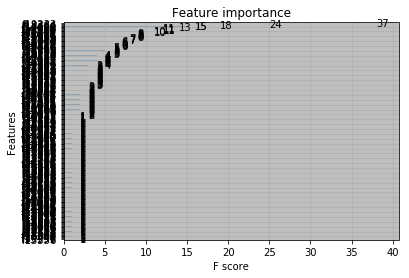

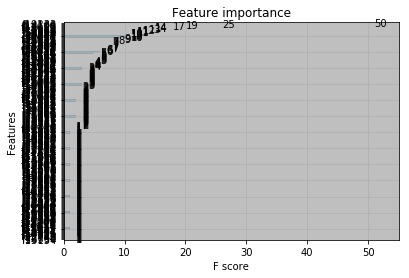

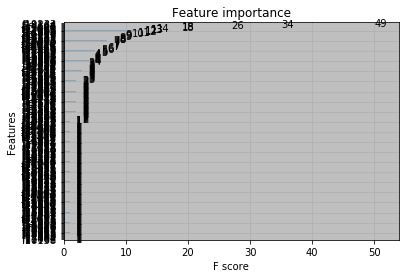

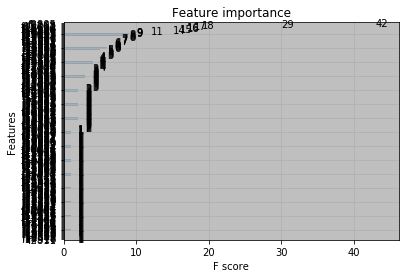

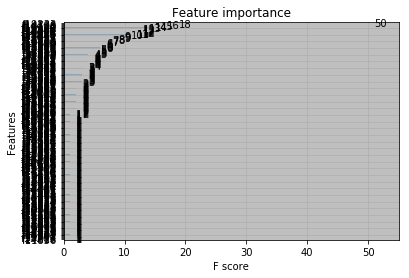

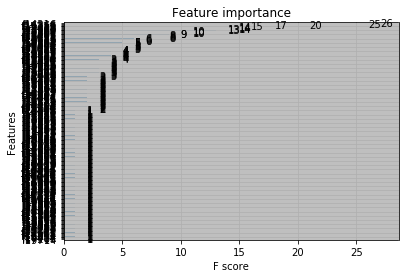

In [43]:
#for col in target_col:
#    model.fit(X, y[col])
#    plot_importance(model)

#pyplot.legend()
#pyplot.show()

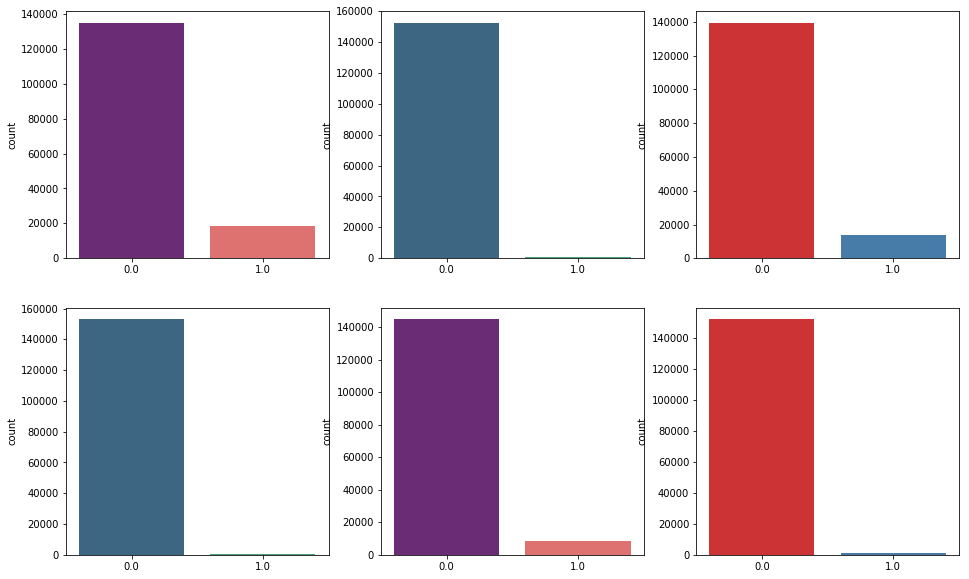

In [55]:
fig,ax = pyplot.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(predictions[:,0], palette = 'magma',ax = ax1)
sns.countplot(predictions[:,1], palette = 'viridis',ax = ax2)
sns.countplot(predictions[:,2], palette = 'Set1',ax = ax3)
sns.countplot(predictions[:,3], palette = 'viridis',ax = ax4)
sns.countplot(predictions[:,4], palette = 'magma',ax = ax5)
sns.countplot(predictions[:,5], palette = 'Set1', ax = ax6)

In [37]:
prd1 = pd.DataFrame(prd,columns=y.columns)
submit1 = pd.concat([test['id'],prd1],axis=1)
submit1.to_csv('xgb_deci.csv',index=False)
submit1.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.991500,0.350874,0.988258,0.057368,0.950708,0.105549
1,0000247867823ef7,0.064053,0.003067,0.018865,0.001099,0.020211,0.004859
2,00013b17ad220c46,0.089355,0.004475,0.054879,0.002147,0.038873,0.004752
3,00017563c3f7919a,0.016307,0.000941,0.009384,0.000665,0.010391,0.001363
4,00017695ad8997eb,0.074528,0.002013,0.021557,0.000952,0.020170,0.003844


In [38]:
prd2 = pd.DataFrame(predictions,columns=y.columns)
submit2 = pd.concat([test['id'],prd2],axis=1)
submit2.to_csv('xgb_int.csv',index=False)
submit2.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.0,0.0,1.0,0.0,1.0,0.0
1,0000247867823ef7,0.0,0.0,0.0,0.0,0.0,0.0
2,00013b17ad220c46,0.0,0.0,0.0,0.0,0.0,0.0
3,00017563c3f7919a,0.0,0.0,0.0,0.0,0.0,0.0
4,00017695ad8997eb,0.0,0.0,0.0,0.0,0.0,0.0
